In [1]:
from numpy import polyfit
from astropy.utils.data import download_file
from astropy.utils.data import Conf 
Conf.remote_timeout = 10
import warnings
warnings.filterwarnings('ignore')
%pylab
%matplotlib inline
from cosmoslik import get_plugin, param, SlikPlugin, SlikDict, run_chain
from cosmoslik.utils import load_chain
rc('text', usetex = True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
class Cepheid(SlikPlugin):
    def __init__(self, **kwargs):
        self.period = kwargs.pop('Period',0)
        self.mag = kwargs.pop('mag',0)
        self.color = kwargs.pop('Color',0)
        self.wmag = self.mag - 0.410 * self.color
        self.Z = kwargs.pop('Z',0)
        self.mag_error = kwargs.pop('e_mag',0)
        self.field = kwargs.pop('Field', '')

        for key, value in kwargs.items():
            setattr(self, key, value)
    def __call__(self, m):
        return 0
    
names = ['Field', 'junk','Sn1a','Filters','mag_av', 'sigma', 'delta_mag','dmag_error','mu_0_Best','mu_best_error']    
class Sne(object):
    def __init__(self, **kwargs):
        self.field = kwargs.pop('Field', '')
        self.name = kwargs.pop('Sn1a', '')
        self.mag_av = kwargs.pop('mag_av',0)
        self.emag_av = kwargs.pop('sigma',0)
        self.delta_mag = kwargs.pop('delta_mag',0)
        self.edelta_mag = kwargs.pop('dmag_error',0)
        self.mu0_best = kwargs.pop('mu_0_Best',0)
        self.emu0_best = kwargs.pop('emu0_Best',0)
        for key, value in kwargs.items():
            setattr(self, key, value)
    def __call__(self, m):
        return 0

In [3]:
class Cepheid_Collection(SlikPlugin):
    def __init__(self, cepheids, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.cepheids = cepheids
        self.period, self.mag, self.color, self.wmag, self.Z, self.mag_error, self.field = map(array, zip(*[[
                    x.period,
                    x.mag,
                    x.color,
                    x.wmag,
                    x.Z,
                    x.mag_error,
                    x.field
                                                            ] for x in cepheids]))
        self.period
        self.fields = ['n3370', 'n4536', 'n3982', 'n5584', 'n4639', 'n4038', 'n4258', 'n3021', 'n1309']
        self.Z = self.Z

    def plot(self, **kwargs):
        fig = kwargs.pop('fig', figure())
        ax = kwargs.pop('ax', subplot(111))
        field = kwargs.pop('field', self.fields[0])
        error = kwargs.pop('error', False)
        if error == False:
            xvals, yvals = zip(*[(x.period, x.wmag) for x in self.cepheids if x.field == field])
            ax.scatter(xvals, yvals , **kwargs);
            ax.invert_yaxis()
            ax.set_xscale('log')
        if error == True:
            xvals, yvals = zip(*[(x.period, x.wmag) for x in self.cepheids if x.field == field])
            ax.scatter(xvals, yvals , **kwargs);
            ax.invert_yaxis()
            ax.set_xscale('log')
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 4))
        ax.yaxis.set_major_locator(MaxNLocator(nbins = 4))
        plt.close(fig)
        return ax
        
class Sne_Collection(object):
    def __init__(self, Sne, **kwargs):
        for key, value, in kwargs.items():
            setattr(self, key, value)
        self.fields = ['n3370', 'n4536', 'n3982', 'n5584', 'n4639', 'n4038', 'n3021', 'n1309']
        (self.field,self.name,self.mag_av,self.emag_av,
         self.delta_mag,self.edelta_mag,self.mu0_best,self.emu0_best) = map(array, zip(*[[
                    x.field,
                    x.name,
                    x.mag_av,
                    x.emag_av,
                    x.delta_mag,
                    x.edelta_mag,
                    x.mu0_best,
                    x.emu0_best
                                                            ] for x in Sne]))

In [79]:
class Hubble_Chain(SlikDict):
    def __init__(self, quad = True, cubic = False):
        self.cepheids, self.sne = get_data()
        self.params = SlikDict()
        for name in self.cepheids.fields:
            self.params[('\delta\mu_p_'+name)] = param(start = 0, scale = .1)
        self.params['\delta\mu_p_n4258'] = 0
        self.params['z_pn4258'] = param(start = 30, scale = 0.1)
        self.params.b = param(start = -3, scale = .05)
        self.params.Z = param(start = -0.224, scale = .06)
        self.params.color_bias = 0#param(start = 0 , scale = 0.04, gaussian_prior= (0,1))
        self.params.SN_mag_4258 = param(start = 12, scale = .1)
        self.params.geo_dist = param(start = 7.5, scale  = 0.32, gaussian_prior = (7.2, 0.32))
        self.params['a_nu'] = param(start = 0.698,scale = 0.00225, gaussian_prior = (0.698,0.00225))
        if quad:
            self.params.b2 = param(start = 0, scale = 0.001)
        else:
            self.params.b2 = 0
        if cubic:
            self.params.b3 = param(start = 0, scale = 0.001)
        else:
            self.params.b3 = 0            
        
        self.sampler = get_plugin('samplers.metropolis_hastings')(self,
                                                                  num_samples=10000,
                                                                  proposal_scale = 1,
                                                                  print_level = 0,  
                                                                  output_file = 'chain.chain',
                                                                 proposal_cov = 'proposal.covmat',
                                                                 proposal_update = True,
                                                                 output_extra_params=['params.H0']
                                                                 )

        self.priors = get_plugin('likelihoods.priors')(self)
        
        
        
    def fitted_ceph_period(self):
        period = self.cepheids.wmag * self.params.b
        period += self.cepheids.wmag**2 *self.params.b2
        period += self.cepheids.wmag**3 * self.params.b3
        period += -self.params['z_pn4258']
        period += 0.410 * self.cepheids.color * self.params.color_bias
        for i, field in enumerate(self.cepheids.fields):
            mask = array([(el == field) for el in self.cepheids.field])
            period += - mask * (self.params['\delta\mu_p_'+field]) * self.params.b
        perr = (self.params.b 
                + 2 * self.params.b2 * self.cepheids.wmag 
                + 3 * self.params.b3 * self.cepheids.wmag**2 ) * self.cepheids.mag_error 
        return period, perr      
        
    def fitted_ceph_mag(self):
        mag = log10(self.cepheids.period) * self.params.b
        mag += (self.cepheids.Z - 8.9) * self.params.Z
        mag += log10(self.cepheids.period)**2 * self.params.b2
        mag += log10(self.cepheids.period)**3 * self.params.b3
        mag += self.params['z_pn4258']
        mag += -0.410 * self.cepheids.color * self.params.color_bias
        for i, field in enumerate(self.cepheids.fields):
            mask = array([(el == field) for el in self.cepheids.field])
            mag += mask * (self.params['\delta\mu_p_'+field]) 
        return mag
    
    def fitted_sne_mag(self):
        mag =self.params.SN_mag_4258
        for i, field in enumerate(self.sne.fields):
            mask = array([(el == field) for el in self.sne.field])
            mag += mask * (self.params['\delta\mu_p_'+field]) 
        return mag
    
    
    def __call__(self):
        self.params['\mu_geometric'] = 5 * log10(self.params.geo_dist) + 25
        self.params.H0 = 10**((self.params.SN_mag_4258 - 
                               self.params['\mu_geometric'] 
                               + 5 * self.params['a_nu'] + 25.0)
                              /5.0)
        cephlnl = sum((self.cepheids.wmag - self.fitted_ceph_mag())**2/self.cepheids.mag_error**2)
        #cephlnl = sum((log10(self.cepheids.period) - self.fitted_ceph_period()[0])**2/self.fitted_ceph_period()[1]**2)
        snelnl = sum((self.sne.mag_av - 5 * self.params['a_nu'] - self.fitted_sne_mag())**2/self.sne.emag_av**2)
        priors = sum(self.priors(self))
        return priors + (cephlnl + snelnl)/2.0
        
    
def get_data():
    filename = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t2_mrt.txt', 
        cache = True)
    data = genfromtxt(filename, 
               skip_header = 39, 
                invalid_raise=False,
                missing_values='',
                usemask=False,
                filling_values=0.0,
                dtype = None);
    names = ['Field', 'RAdeg', 'DEdeg', 'ID',  'Period',  
             'Color',  'mag', 'e_mag', 'Offset', 'Bias', 'IMrms', 'Z']
    data = [dict(zip(names, x)) for x in data]
    cepheids =  Cepheid_Collection([Cepheid(**x) for x in data])
    
    
    filename = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t3_ascii.txt',
        cache = True)
    data = genfromtxt(filename,
                  skip_header = 4,
                  invalid_raise = False,
                  missing_values = '',
                  usemask=False,
                  filling_values = 0.0,
                  dtype = None
                 );
    names = ['Field', 'junk','Sn1a','Filters','mag_av', 
             'sigma', 'delta_mag','dmag_error','mu_0_Best','mu_best_error']
    data = [dict(zip(names, x)) for x in data]
    sne = Sne_Collection([Sne(**x) for x in data])
    
    return cepheids, sne

In [80]:
std_chain = run_chain(Hubble_Chain, kwargs ={'quad':False}).burnin(0)
print std_chain.acceptance()
x =  zip(std_chain.params(),std_chain.mean(),std_chain.std())
for i in x:
    print i

0.60596059606
('params.\\delta\\mu_p_n3982', 2.1182833323605723, 0.50588083591188004)
('params.b', -2.9208210265370762, 0.12163961639479913)
('params.\\delta\\mu_p_n4536', 1.4533654461674272, 0.31904549796335657)
('params.\\delta\\mu_p_n3370', 2.4469813278101746, 0.66042150682095269)
('params.z_pn4258', 26.495066743213023, 0.78499397797371961)
('params.\\delta\\mu_p_n3021', 2.5681477164370308, 0.75161836081692335)
('params.\\delta\\mu_p_n1309', 2.8122636031432955, 0.76497247580342453)
('params.\\delta\\mu_p_n4639', 1.9959180764122684, 0.63061635733808397)
('params.\\delta\\mu_p_n4038', 1.9766979348703286, 0.57014136148999262)
('params.a_nu', 0.70060209379615335, 0.0068924583763742796)
('params.SN_mag_4258', 10.469748416536641, 0.49792206951276419)
('params.Z', -0.34818332402807367, 0.24985783940716769)
('params.\\delta\\mu_p_n5584', 2.1248062360363273, 0.50374920765303244)
('params.geo_dist', 7.4982120322694001, 0.98685963025646029)


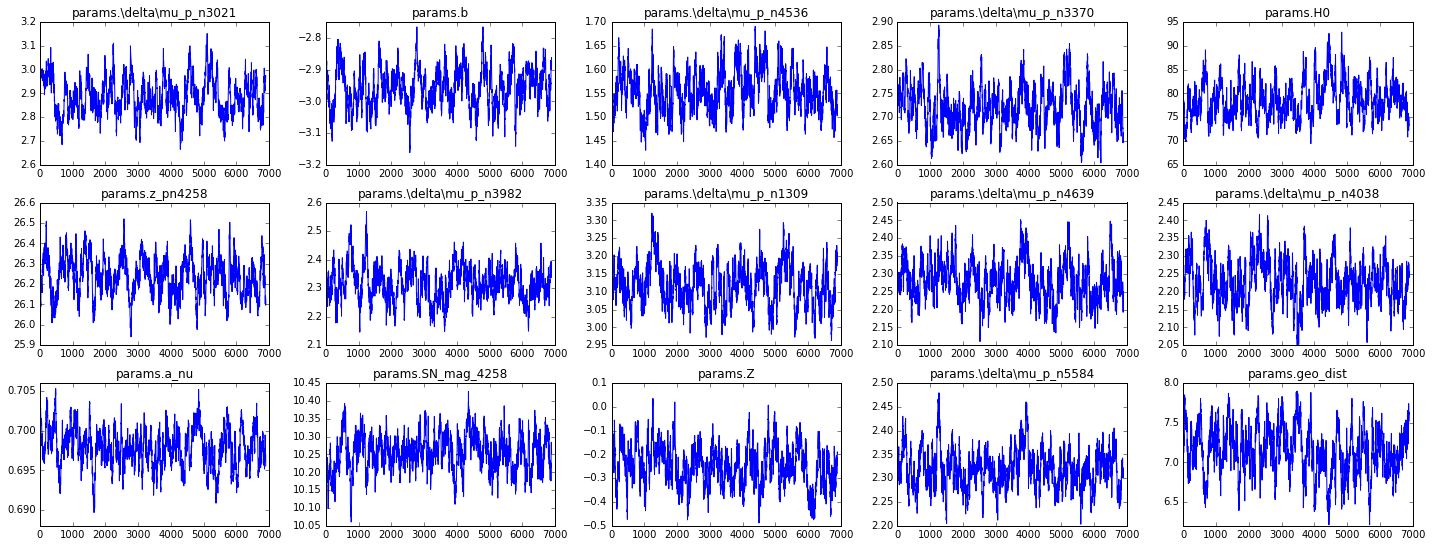

In [81]:
std_chain = load_chain('chain.chain').burnin(3000).join()
rc('text', usetex = False)
std_chain.plot()
std_chain.savecov('proposal.covmat')

In [82]:
quad_chain = run_chain(Hubble_Chain)
print quad_chain.acceptance()



0.616361636164


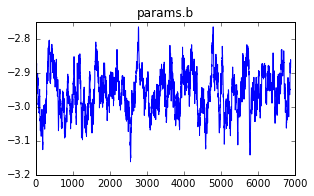

In [83]:
quad_chain = load_chain('chain.chain').burnin(5000).join()
std_chain.savecov('proposal.covmat')
std_chain.plot('params.b')


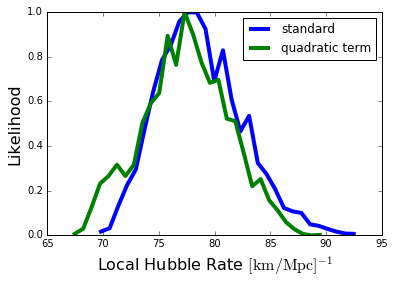

In [84]:
std_chain.like1d('params.H0', linewidth = 4, label = 'standard')
quad_chain.like1d('params.H0', color = 'g', linewidth = 4, label = 'quadratic term')
legend()
#cubic_chain.like1d('params.H0', color = 'r', linewidth = 4)
ylabel('Likelihood', fontsize = 16)
xlabel(r'Local Hubble Rate $[{\rm km/Mpc}]^{-1}$', fontsize = 16)


In [85]:
std_chain['params.b2'] = std_chain['params.b']*0
#std_chain.likegrid()
#quad_chain.likegrid(color = 'g')


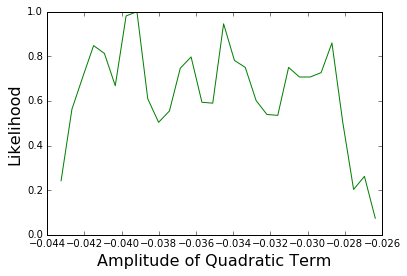

In [86]:
quad_chain.like1d('params.b2', color = 'g')
#cubic_chain.like1d('params.b2', color = 'r')
xlabel('Amplitude of Quadratic Term', fontsize = 16)
ylabel('Likelihood', fontsize = 16)
savefig('/Users/follin/Downloads/quad_term.png')

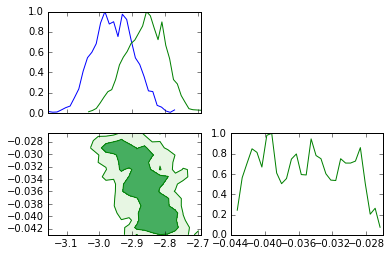

In [87]:
fig = figure()
ax1 = fig.add_subplot(221)
setp(ax1.get_xticklabels(), visible=False)
std_chain.like1d('params.b')
quad_chain.like1d('params.b', color = 'g')
ax4 = fig.add_subplot(224)
quad_chain.like1d('params.b2', color = 'g')
ax3 = fig.add_subplot(223, sharex = ax1)
quad_chain.like2d('params.b', 'params.b2', bins = 50, color = 'g')
ax3.xaxis.set_major_locator(MaxNLocator(nbins = 5))
ax4.xaxis.set_major_locator(MaxNLocator(nbins = 5))



In [88]:
x =  zip(std_chain.params(),std_chain.mean(),std_chain.std(),quad_chain.mean(),quad_chain.std())
for i in x:
    print '%s: \t %3.4f \pm %3.4f (no quadratic term) \t %3.4f \pm %3.4f (quadratic term)'%i

params.\delta\mu_p_n3021: 	 2.8880 \pm 0.0764 (no quadratic term) 	 2.8842 \pm 0.0753 (quadratic term)
params.b: 	 -2.9576 \pm 0.0617 (no quadratic term) 	 -2.8612 \pm 0.0601 (quadratic term)
params.\delta\mu_p_n4536: 	 1.5561 \pm 0.0436 (no quadratic term) 	 1.5556 \pm 0.0441 (quadratic term)
params.\delta\mu_p_n3370: 	 2.7218 \pm 0.0436 (no quadratic term) 	 2.7158 \pm 0.0447 (quadratic term)
params.H0: 	 78.7182 \pm 3.7734 (no quadratic term) 	 77.4008 \pm 3.8596 (quadratic term)
params.z_pn4258: 	 26.2385 \pm 0.0934 (no quadratic term) 	 26.1775 \pm 0.0812 (quadratic term)
params.\delta\mu_p_n3982: 	 2.3178 \pm 0.0602 (no quadratic term) 	 2.3205 \pm 0.0637 (quadratic term)
params.\delta\mu_p_n1309: 	 3.1189 \pm 0.0578 (no quadratic term) 	 3.1182 \pm 0.0522 (quadratic term)
params.\delta\mu_p_n4639: 	 2.2796 \pm 0.0562 (no quadratic term) 	 2.2671 \pm 0.0686 (quadratic term)
params.\delta\mu_p_n4038: 	 2.2268 \pm 0.0603 (no quadratic term) 	 2.2236 \pm 0.0794 (quadratic term)
para

In [89]:
std_chain.best_fit()['lnl'] - quad_chain.best_fit()['lnl']

-0.69306744158586753

In [90]:
std_chain.best_fit()['params.H0']

78.34515553869835

In [91]:
self = Hubble_Chain(quad = False)

In [92]:
self.params.H0 = 77
self.params.SN_mag_4258 = 10.22
self.params.Z = -0.25
self.params['\\delta\\mu_p_n1309'] = 3
self.params['\\delta\\mu_p_n3021'] = 3
self.params['\\delta\\mu_p_n3370'] = 3
self.params['\\delta\\mu_p_n3982'] = 3
self.params['\\delta\\mu_p_n4038'] = 3
self.params['\\delta\\mu_p_n4536'] = 3
self.params['\\delta\\mu_p_n4639'] = 3
self.params['\\delta\\mu_p_n5584'] = 3
self.params.a_nu = 0.699
self.params.b = -2.97
self.params.geo_dist = 7
self.params.z_pn4258 = 26.



In [102]:
from scipy.optimize import minimize


keys, params = (self.params.keys(), self.params.values())
def lnl(args):
    for i, arg in enumerate(args):
        self.params[keys[i]] = arg    
    cephlnl = sum((self.cepheids.wmag - self.fitted_ceph_mag())**2/self.cepheids.mag_error**2)
    #cephlnl = sum((log10(self.cepheids.period) - self.fitted_ceph_period()[0])**2/self.fitted_ceph_period()[1]**2)
    snelnl = sum((self.sne.mag_av - 5 * self.params['a_nu'] - self.fitted_sne_mag())**2/self.sne.emag_av**2)
    priors = sum(self.priors(self))
    return priors + (cephlnl + snelnl)
res = minimize(lnl, params, method = 'TNC')
print res.fun
popt = res.x
bestfit = dict()
for key, p in zip(keys, popt):
    bestfit[key] = p
    
bestfit['\mu_geometric'] = 5 * log10(bestfit['geo_dist']) + 25
bestfit['H0'] = 10**((bestfit['SN_mag_4258'] - 
                               bestfit['\mu_geometric'] 
                               + 5 * bestfit['a_nu'] + 25.0)
                              /5.0)
print bestfit


435.801549945
{'\\delta\\mu_p_n3982': 2.3699060654720179, 'z_pn4258': 26.463263230673252, 'b': -3.1841438229015901, 'Z': -0.23734284135203862, 'b2': -0.02792263463751149, 'geo_dist': 7.1938210782868266, '\\delta\\mu_p_n3021': 2.9256660634547687, '\\mu_geometric': 29.284798160129284, 'H0': 76.214293282299536, '\\delta\\mu_p_n4038': 2.2594927222717813, '\\delta\\mu_p_n5584': 2.3664732029065099, '\\delta\\mu_p_n4536': 1.5946091117715937, '\\delta\\mu_p_n1309': 3.1753572732610369, '\\delta\\mu_p_n3370': 2.7660157204092561, '\\delta\\mu_p_n4639': 2.3275029692991729, '\\delta\\mu_p_n4258': 0.050824372732957826, 'b3': 0.042013133631849393, 'SN_mag_4258': 10.206170049767749, 'color_bias': 0.052832303156516935, 'a_nu': 0.69776204894360994}


In [103]:
print std_chain.best_fit()['lnl']
print std_chain.best_fit()['params.H0']

221.841159079
78.3451555387


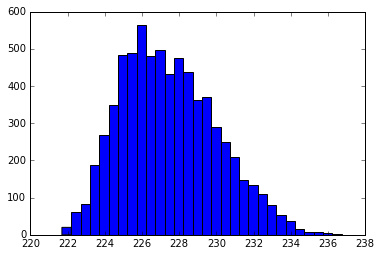

In [78]:
hist(std_chain['lnl'], weights = std_chain['weight'], bins = 30);

In [75]:
histogram?